In [1]:
!pip install "gym[atari, accept-rom-license]"

In [ ]:
import os
import gym
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List

In [57]:
Array = np.ndarray
Model = Dict[Array, Array]
TrajectoryBuffer = Dict[str, List]
GradientsMap = Dict[str, Array]

In [81]:
def preprocess(frame: Array) -> Array:
    """
        Preprocess 210x160x3 uint8 frame into 6400 (80x80) 1D float vector.
    """
    if isinstance(frame, tuple):
        frame = frame[0]
        
    frame = frame[35:195] 
    frame = frame[::2,::2,0] 
    frame[frame == 144] = 0 
    frame[frame == 109] = 0 
    frame[frame != 0] = 1
    return frame.astype(float).ravel()


def relu(input_array: Array) -> Array:
    output = np.copy(input_array)
    output[input_array < 0] = 0
    return output


def relu_prime(input_array: Array) -> Array:
    derivative = np.zeros_like(input_array)
    derivative[input_array > 0] = 1
    return derivative


def sigmoid(value: Array) -> Array:
    return 1.0 / (1.0 + np.exp(-value))


def forward(input_vec: Array, network: Model, buffer: TrajectoryBuffer) -> float:
    """
        Perform a forward pass to compute the probability of taking the 'up' action.
    """
    pre_hidden = np.dot(network['input_to_hidden'], input_vec)
    hidden = relu(pre_hidden)
    pre_output = np.dot(network['hidden_to_output'], hidden)
    output_prob = sigmoid(pre_output)

    buffer['input'].append(input_vec)
    buffer['pre_activation'].append(pre_hidden)
    buffer['hidden'].append(hidden)
    buffer['output'].append(output_prob)

    return output_prob


def backward(network: Model, buffer: TrajectoryBuffer, rewards: Array) -> GradientsMap:
    """
        Perform a backward pass to compute gradients of the network weights.
    """
    predicted_output = np.vstack(buffer['output'])
    actual_output = np.vstack(buffer['target'])
    hidden_layer = np.vstack(buffer['hidden'])
    pre_hidden_layer = np.vstack(buffer['pre_activation'])
    input_data = np.vstack(buffer['input'])

    output_error = actual_output - predicted_output
    advantage = output_error * rewards  

    grad_output_weights = np.dot(advantage.T, hidden_layer)
    grad_hidden = np.dot(advantage, network['hidden_to_output'])
    grad_pre_hidden = relu_prime(pre_hidden_layer) * grad_hidden
    grad_input_weights = np.dot(grad_pre_hidden.T, input_data)

    return {'input_to_hidden': grad_input_weights, 'hidden_to_output': grad_output_weights}


def compute_normalized_discounted_rewards(buffer: TrajectoryBuffer, gamma: float) -> float:
    """
        Compute discounted and normalized rewards for a given trajectory.
    """
    rewards = buffer['reward']
    discounted = np.zeros((len(rewards), 1))
    accumulated = 0
    for t in range(len(rewards) - 1, -1, -1):
        if rewards[t] != 0: 
            accumulated = 0
        discounted[t][0] = rewards[t] + gamma * accumulated
        accumulated = discounted[t][0]
    discounted -= np.mean(discounted)
    discounted /= np.std(discounted)
    return discounted


In [82]:
batch_history = {
    'batch_num': [],
    'avg_reward': [],
    'min_reward': [],
    'max_reward': []
}

def train_model(model_path: str, save_path: str, visualize: bool, max_batches: int = 10) -> Model:
    """
        Train the agent and record performance over time.
    """
    batch_size = 10
    input_size = 6400
    hidden_size = 200
    alpha = 1e-3
    gamma = 0.99
    decay_rate = 0.90
    epsilon = 1e-5

    if model_path is not None:
        checkpoint = pkl.load(open(model_path, 'rb'))
        network = checkpoint['model']
        grad_cache = checkpoint['moving_grad_rms']
        episode_idx = checkpoint['episode_number']
        print(f"Loaded model from '{model_path}'")
    else:
        network = {
            'input_to_hidden': np.random.randn(hidden_size, input_size) / np.sqrt(input_size),
            'hidden_to_output': np.random.randn(1, hidden_size) / np.sqrt(hidden_size),
        }
        grad_cache = {
            'input_to_hidden': np.zeros_like(network['input_to_hidden']),
            'hidden_to_output': np.zeros_like(network['hidden_to_output']),
        }
        episode_idx = 0

    accumulated_grads = {
        'input_to_hidden': np.zeros_like(network['input_to_hidden']),
        'hidden_to_output': np.zeros_like(network['hidden_to_output']),
    }

    rewards_per_batch = []

    env = gym.make('ALE/Pong-v5', render_mode="human" if visualize else None)

    while episode_idx // batch_size < max_batches:
        observation, _ = env.reset()
        prev_obs = np.zeros(input_size)
        episode_complete = False
        step_count = 0

        buffer = {
            'input': [], 'pre_activation': [], 'hidden': [],
            'output': [], 'target': [], 'reward': []
        }

        while not episode_complete:
            if visualize:
                env.render()

            processed_obs = preprocess(observation)
            diff_input = processed_obs - prev_obs
            prev_obs = processed_obs

            output_prob = forward(diff_input, network, buffer)
            selected_action, label = (2, 1.0) if np.random.uniform() < output_prob else (5, 0.0)
            buffer['target'].append(label)

            observation, reward, episode_complete, _, _ = env.step(selected_action)
            buffer['reward'].append(reward)
            step_count += 1

            if episode_complete:
                reward_signal = compute_normalized_discounted_rewards(buffer, gamma)
                grads = backward(network, buffer, reward_signal)
                for param in network:
                    accumulated_grads[param] += grads[param]

                rewards_per_batch.append(sum(buffer['reward']))
                episode_idx += 1

                if episode_idx % batch_size == 0:
                    batch_num = episode_idx // batch_size
                    mean_reward = np.mean(rewards_per_batch)
                    min_r = np.min(rewards_per_batch)
                    max_r = np.max(rewards_per_batch)

                    batch_history['batch_num'].append(batch_num)
                    batch_history['avg_reward'].append(mean_reward)
                    batch_history['min_reward'].append(min_r)
                    batch_history['max_reward'].append(max_r)

                    print(f'Batch: {batch_num}, Avg: {mean_reward:.1f}, Min: {min_r:.1f}, Max: {max_r:.1f}')

                    for param in network:
                        grad_cache[param] = decay_rate * grad_cache[param] + \
                            (1 - decay_rate) * (accumulated_grads[param] ** 2)
                        network[param] += alpha * accumulated_grads[param] / \
                            (np.sqrt(grad_cache[param]) + epsilon)
                        accumulated_grads[param] = np.zeros_like(network[param])

                    rewards_per_batch = []

                if episode_idx % 50 == 0 and save_path is not None:
                    os.makedirs(save_path, exist_ok=True)
                    fname = os.path.join(save_path, f'model_checkpoint_{episode_idx}.pkl')
                    pkl.dump({
                        'model': network,
                        'moving_grad_rms': grad_cache,
                        'episode_number': episode_idx
                    }, open(fname, 'wb'))

    env.close()
    return network

In [83]:
def evaluate_model(model: Model, num_episodes: int = 10):
    """
        Evaluate the trained model and compute the average reward over multiple episodes.
    """
    env = gym.make('ALE/Pong-v5', render_mode="human")
    input_dim = 6400
    rewards = []

    for ep in range(num_episodes):
        observation, _ = env.reset()
        prev_obs = np.zeros(input_dim)
        done = False
        episode_reward = 0

        while not done:
            env.render()
            current_frame = preprocess(observation)
            input_frame = current_frame - prev_obs
            prev_obs = current_frame

            prob = forward(input_frame, model, {'input': [], 'pre_activation': [], 'hidden': [], 'output': []})
            chosen_action = 2 if prob > 0.5 else 5

            observation, reward, done, _, _ = env.step(chosen_action)
            episode_reward += reward

        rewards.append(episode_reward)
        print(f"Episode {ep + 1}: Total Reward = {episode_reward}")

    avg_reward = np.mean(rewards)
    print(f"\nAverage Reward over {num_episodes} episodes: {avg_reward:.2f}")
    
    env.close()

In [ ]:
trained_model = train_model(
    model_path=None,
    save_path=None,
    renvisualizeder=False,
    max_batches=500
)

Batch: 1, Avg: -19.3, Min: -21.0, Max: -17.0
Batch: 2, Avg: -20.1, Min: -21.0, Max: -18.0
Batch: 3, Avg: -20.2, Min: -21.0, Max: -19.0
Batch: 4, Avg: -20.5, Min: -21.0, Max: -19.0
Batch: 5, Avg: -20.0, Min: -21.0, Max: -19.0
Batch: 6, Avg: -20.2, Min: -21.0, Max: -19.0
Batch: 7, Avg: -20.0, Min: -21.0, Max: -19.0
Batch: 8, Avg: -20.1, Min: -21.0, Max: -18.0
Batch: 9, Avg: -19.7, Min: -21.0, Max: -18.0
Batch: 10, Avg: -20.1, Min: -21.0, Max: -17.0
Batch: 11, Avg: -19.9, Min: -21.0, Max: -19.0
Batch: 12, Avg: -19.8, Min: -21.0, Max: -19.0
Batch: 13, Avg: -20.1, Min: -21.0, Max: -19.0
Batch: 14, Avg: -19.4, Min: -21.0, Max: -18.0
Batch: 15, Avg: -20.2, Min: -21.0, Max: -18.0
Batch: 16, Avg: -19.6, Min: -21.0, Max: -17.0
Batch: 17, Avg: -20.0, Min: -21.0, Max: -18.0
Batch: 18, Avg: -19.9, Min: -21.0, Max: -19.0
Batch: 19, Avg: -20.3, Min: -21.0, Max: -19.0
Batch: 20, Avg: -20.3, Min: -21.0, Max: -19.0
Batch: 21, Avg: -19.9, Min: -21.0, Max: -18.0
Batch: 22, Avg: -19.9, Min: -21.0, Max: -16

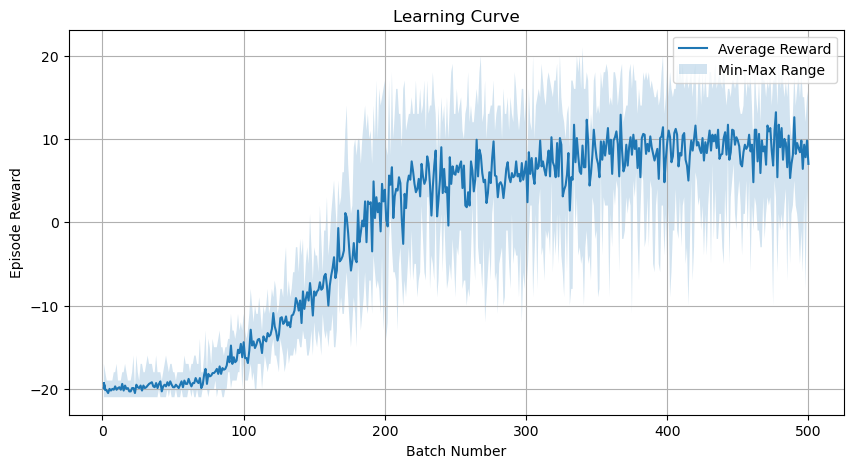

In [ ]:
# Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(batch_history['batch_num'], batch_history['avg_reward'], label='Average Reward')
plt.fill_between(batch_history['batch_num'], 
                batch_history['min_reward'], 
                batch_history['max_reward'], 
                alpha=0.2, label='Min-Max Range')

plt.xlabel('Batch Number')
plt.ylabel('Episode Reward')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

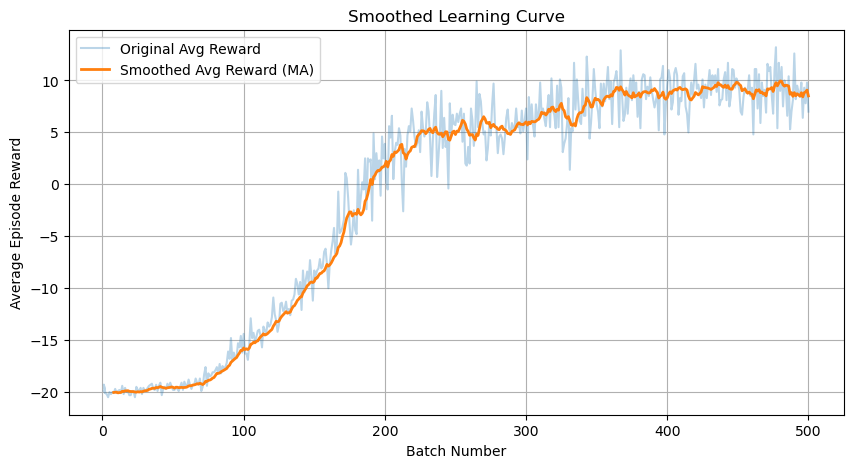

In [ ]:
# Plot smoothed learning curve
def moving_average(data, window=10):
    return np.convolve(data, np.ones(window)/window, mode='valid')

smoothed_rewards = moving_average(batch_history['avg_reward'], window=10)
valid_batch_nums = batch_history['batch_num'][len(batch_history['batch_num']) - len(smoothed_rewards):]

plt.figure(figsize=(10, 5))
plt.plot(batch_history['batch_num'], batch_history['avg_reward'], label='Original Avg Reward', alpha=0.3)
plt.plot(valid_batch_nums, smoothed_rewards, label='Smoothed Avg Reward (MA)', linewidth=2)

plt.xlabel('Batch Number')
plt.ylabel('Average Episode Reward')
plt.title('Smoothed Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

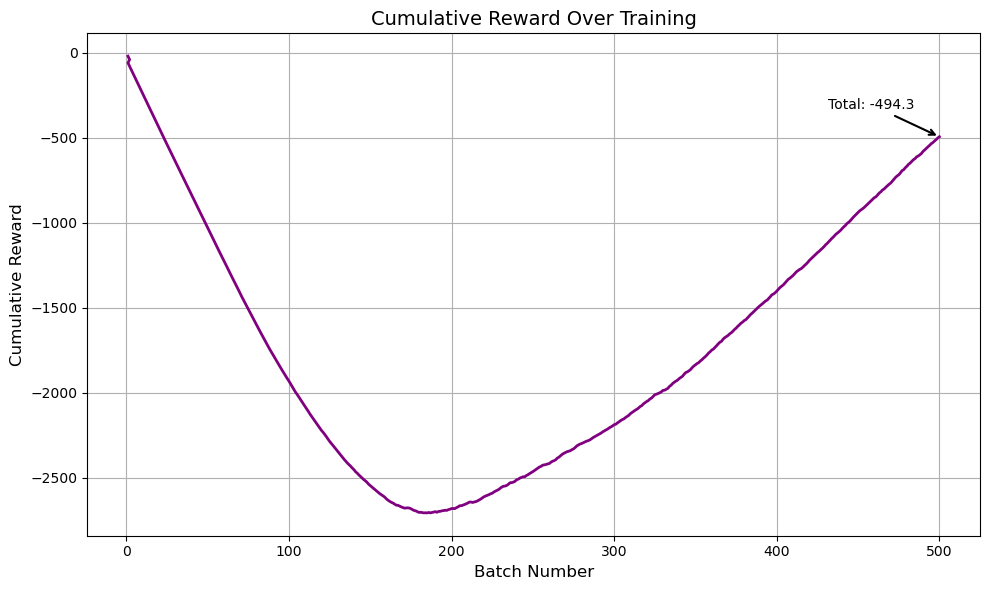

In [ ]:
# Calculate and plot the cumulative reward
cumulative_rewards = np.cumsum(batch_history['avg_reward'])

plt.figure(figsize=(10, 5))
plt.plot(batch_history['batch_num'], cumulative_rewards, color='purple', linewidth=2)

plt.xlabel('Batch Number', fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=12)
plt.title('Cumulative Reward Over Training', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.annotate(f'Total: {cumulative_rewards[-1]:.1f}',
             xy=(batch_history['batch_num'][-1], cumulative_rewards[-1]),
             xytext=(-80, 20),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', lw=1.5),
             fontsize=10)

plt.tight_layout()
plt.show()

In [55]:
# Evaluate the trained model
print("\n=== Evaluating Trained Model ===")
evaluate_model(trained_model, num_episodes=15)


=== Evaluating Trained Model ===
Episode 1: Total Reward = 4.0
Episode 2: Total Reward = 8.0
Episode 3: Total Reward = 3.0
Episode 4: Total Reward = 13.0
Episode 5: Total Reward = 5.0
Episode 6: Total Reward = 20.0
Episode 7: Total Reward = 13.0
Episode 8: Total Reward = 12.0
Episode 9: Total Reward = 11.0
Episode 10: Total Reward = 9.0
Episode 11: Total Reward = 7.0
Episode 12: Total Reward = 16.0
Episode 13: Total Reward = 6.0
Episode 14: Total Reward = 2.0
Episode 15: Total Reward = 13.0

Average Reward over 15 episodes: 9.47


In [ ]:
with open('pong_model.pkl', 'wb') as f:
    pkl.dump(trained_model, f)
print("Model saved as pong_model-500.pkl")

Model saved as pong_model-500.pkl


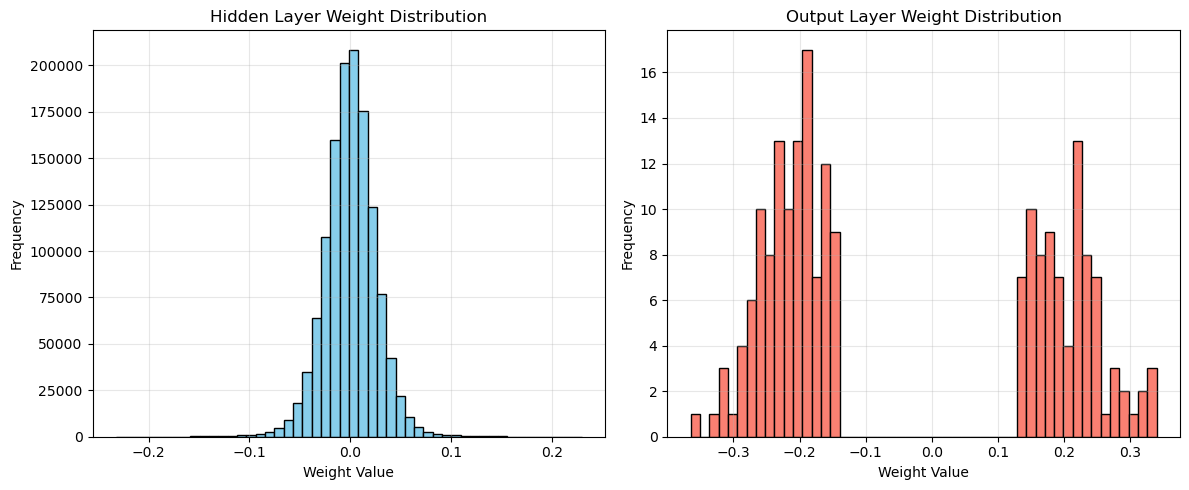

In [ ]:
# Plot weight distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(trained_model['input_to_hidden'].flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Hidden Layer Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(trained_model['hidden_to_output'].flatten(), bins=50, color='salmon', edgecolor='black')
plt.title('Output Layer Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

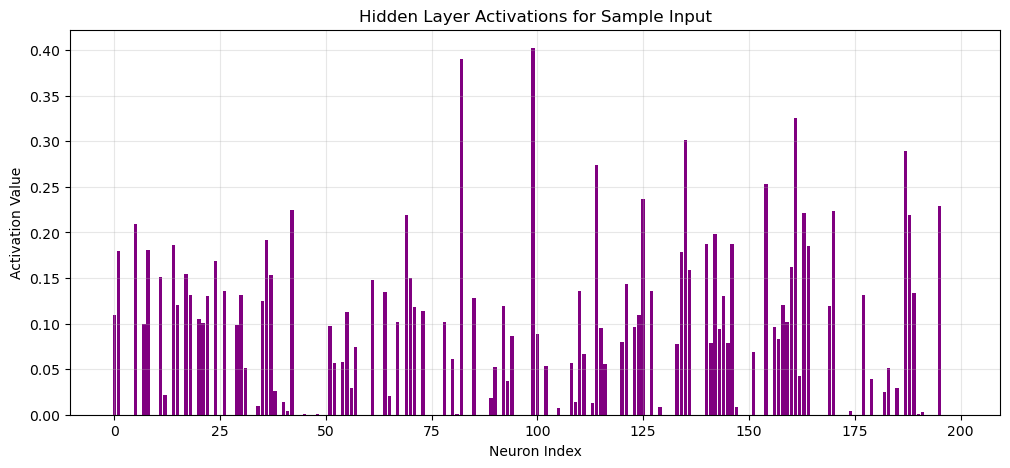

In [ ]:
# Plot neuron activations for a sample game frame
def plot_neuron_activations(model, sample_input):
    buffer = {'input': [], 'pre_activation': [], 'hidden': [], 'output': []}
    forward(sample_input, model, buffer)
    
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(buffer['hidden'][0])), buffer['hidden'][0], color='purple')
    plt.title('Hidden Layer Activations for Sample Input')
    plt.xlabel('Neuron Index')
    plt.ylabel('Activation Value')
    plt.grid(True, alpha=0.3)
    plt.show()

sample_obs, _ = gym.make('ALE/Pong-v5').reset()
sample_input = preprocess(sample_obs) - np.zeros(6400)
plot_neuron_activations(trained_model, sample_input)

/var/folders/d4/rk_tkbyn3njg7p7vs9ncwvrh0000gn/T/ipykernel_64708/2133627333.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob_matrix[i,j] = forward(synthetic_input, model, {'x': [], 'ph': [], 'h': [], 'y': []})


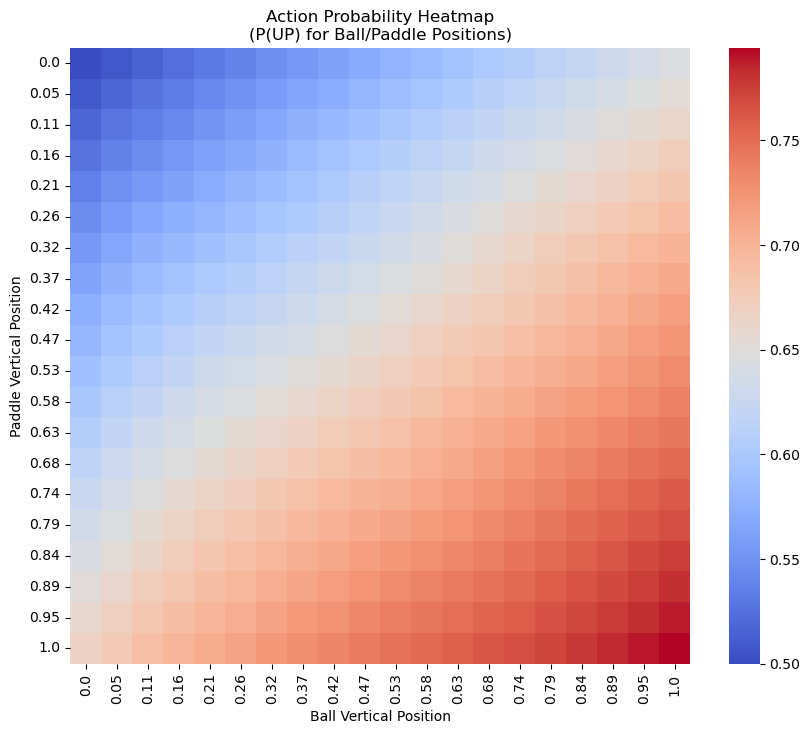

In [ ]:
# Plot action probability heatmap
def plot_action_heatmap(model):
    paddle_pos = np.linspace(0, 1, 20)
    ball_pos = np.linspace(0, 1, 20)
    
    prob_matrix = np.zeros((20, 20))
    
    for i, paddle in enumerate(paddle_pos):
        for j, ball in enumerate(ball_pos):
            synthetic_input = np.zeros(6400)
            synthetic_input[::80] = ball 
            synthetic_input[70::80] = paddle 
            prob_matrix[i,j] = forward(synthetic_input, model, {'input': [], 'pre_activation': [], 'hidden': [], 'output': []})
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(prob_matrix, annot=False, cmap='coolwarm', 
                xticklabels=np.round(ball_pos, 2), 
                yticklabels=np.round(paddle_pos, 2))
    plt.title('Action Probability Heatmap\n(P(UP) for Ball/Paddle Positions)')
    plt.xlabel('Ball Vertical Position')
    plt.ylabel('Paddle Vertical Position')
    plt.show()

plot_action_heatmap(trained_model)

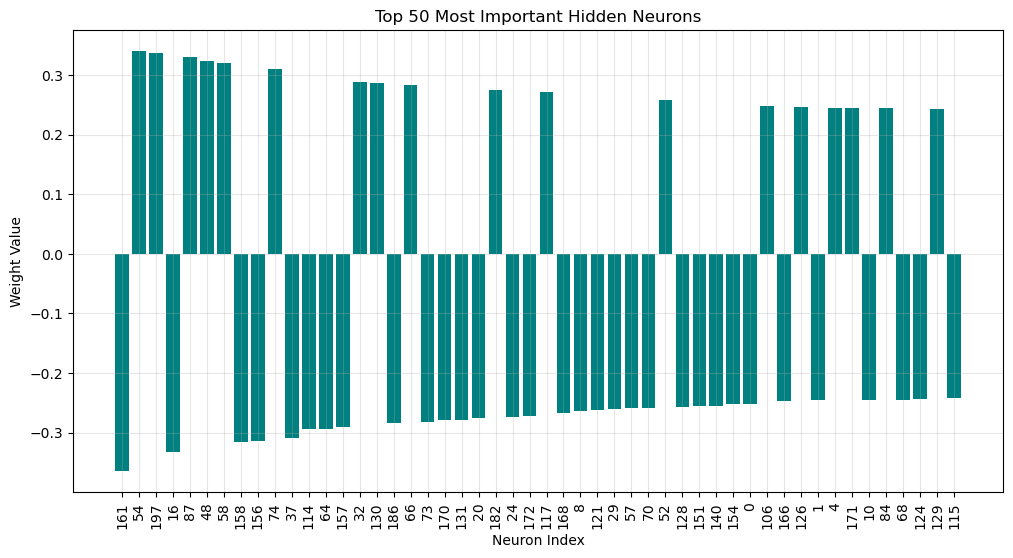

In [ ]:
# Plot 50 most important hidden neurons
def plot_important_weights(model, top_n=50):
    output_weights = model['hidden_to_output'].flatten()
    top_indices = np.argsort(-np.abs(output_weights))[:top_n]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(top_n), output_weights[top_indices], color='teal')
    plt.xticks(range(top_n), top_indices, rotation=90)
    plt.title(f'Top {top_n} Most Important Hidden Neurons')
    plt.xlabel('Neuron Index')
    plt.ylabel('Weight Value')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_important_weights(trained_model)